In [51]:
import numpy as np

# Define rotation array R 

def coordinate_transform(coordinates):
    """
    Returns rotation matrix R for transforming unit vectors in the local detector frame (X, Y, Z). 
    to unit vectors in the wave frame (x, y, z). (x, y, z) = R(phi_n, theta_n, psi)(X, Y, Z). 
    
    Parameters: 
    coordinates --- 1x3 matrix of coordinates [theta_n, phi_n, psi] where theta_n and phi_n are described from the 
                    reversed direction of propagation z: \hat{n} = - \hat{z}. theta_n must be in the range [0, pi] 
                    where 0 is defined as the Z axis. phi_n must be in the range [0, 2pi] where 0 is defined as the 
                    X axis. The polarization angle psi is defined as a rotation around the z axis. 
                
    Returns: 
    R --- Rotation matrix for describing the (x, y, z) unit vectors in terms of phi_n, theta_n, psi angles in the 
          detector frame (X, Y, Z). 
    """
    theta_n, phi_n, psi = coordinates
    
    # abs(theta_n) and phi_n must be in the following ranges, otherwise the conversion to theta and phi doesn't work
    assert 0 <= np.abs(theta_n.all()) <= np.pi
    assert 0 <= phi_n.all() <= 2 * np.pi
    
    # conversion to theta and phi defined from z axis 
    theta = np.pi - np.abs(theta_n)
    phi = np.pi + phi_n

    R_list = [[np.cos(psi) * np.cos(phi) - np.cos(theta) * np.sin(phi) * np.sin(psi), 
          np.sin(phi) * np.cos(psi) + np.cos(theta) * np.sin(psi) * np.cos(phi),
          np.sin(theta) * np.sin(psi)], 
         [-np.cos(phi) * np.sin(psi) - np.cos(theta) * np.cos(psi) * np.sin(phi), 
          -np.sin(psi) * np.sin(phi) + np.cos(theta) * np.cos(psi) * np.cos(phi),
          np.sin(theta) * np.cos(psi)], 
         [np.sin(theta) * np.sin(phi), - np.sin(theta) * np.cos(phi), np.cos(theta)]
        ]

    R = np.array(R_list)
    return R

In [52]:
# Define constant tensors

D = np.array([
        [1, 0, 0],
        [0, -1, 0],
        [0, 0, 0]
                ]) / 2 # factor of 2 in order to agree with paper 

eps_plus = np.array([
    [1, 0, 0],
    [0, -1, 0],
    [0, 0, 0]
])

eps_cross = np.array([
    [0, 1, 0],
    [1, 0, 0],
    [0, 0, 0]
])

In [53]:
# Define antenna response

def F(coordinates, D):
    """
    Describes antenna response F given a set of coordinates describing the unit vector n in the (X, Y, Z) detector
    frame and the detector tensor D. Utilizes the polarization tensors epsilon_plus and epsilon_cross as constants. 
    
    Parameters: 
    coordinates --- 1x3 matrix of coordinates [theta_n, phi_n, psi] where theta_n and phi_n are described from the 
                    reversed direction of propagation z: \hat{n} = - \hat{z}. theta_n must be in the range [0, pi] 
                    where 0 is defined as the Z axis. phi_n must be in the range [0, 2pi] where 0 is defined as the 
                    X axis. The polarization angle psi is defined as a rotation around the z axis. 
    D --- 3x3 matrix of numbers describing detector response 
                
    Returns: 
    F --- 1x2 array containing antenna responses F_plus and F_cross for the given polarizations as the 0th and 1st 
          indices respectively. 
    """
    
    # Initializing values
    F_plus = 0
    F_cross = 0
    
    # Summing over indexes 
    for mu in range(3): 
        for eta in range(3): 
            for rho in range(3):
                for sig in range(3): 
                    F_plus += D[mu][eta] * eps_plus[rho][sig] * coordinate_transform(coordinates)[rho][mu] * coordinate_transform(coordinates)[sig][eta]
                    F_cross += D[mu][eta] * eps_cross[rho][sig] * coordinate_transform(coordinates)[rho][mu] * coordinate_transform(coordinates)[sig][eta]
    
    F = np.array([F_plus, F_cross])
    
    return F 

In [54]:
# Plot figures

import matplotlib.pyplot as plt
from matplotlib import cm, colors
from mpl_toolkits.mplot3d import Axes3D

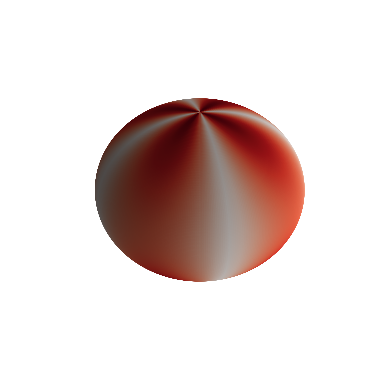

In [55]:
# Spherical plot of F_plus

polarization_angle = 0 #psi value

# Create grid of theta and phi values 
theta_range = np.linspace(0, np.pi, 180)
phi_range = np.linspace(0, 2 * np.pi, 360)
phi_grid, theta_grid = np.meshgrid(phi_range, theta_range)

coordinate_array = [theta_grid, phi_grid, polarization_angle]
data = np.abs(F(coordinate_array, D)[0]) # F_plus

# The Cartesian coordinates of the unit sphere
x = np.sin(theta_grid) * np.cos(phi_grid)
y = np.sin(theta_grid) * np.sin(phi_grid)
z = np.cos(theta_grid)

# Set the aspect ratio to 1
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.Reds(data))

# Turn off the axis planes
ax.set_axis_off()
plt.show()

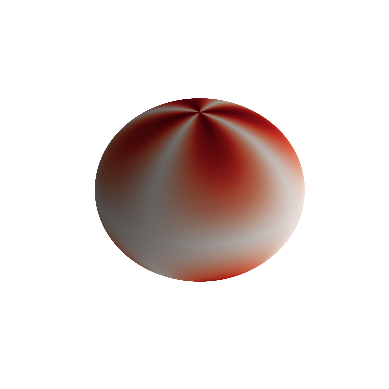

In [56]:
# Spherical plot of F_cross

data = np.abs(F(coordinate_array, D)[1]) 


fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.Reds(data))
ax.set_axis_off()
plt.show()

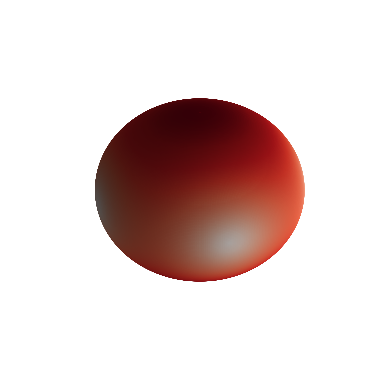

In [57]:
# Spherical plot of sqrt(F_plus^2 + F_cross^2)

data = np.sqrt(np.abs(F(coordinate_array, D)[0]) ** 2 + np.abs(F(coordinate_array, D)[1]) ** 2) 

fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z,  rstride=1, cstride=1, facecolors=cm.Reds(data))
ax.set_axis_off()
plt.show()

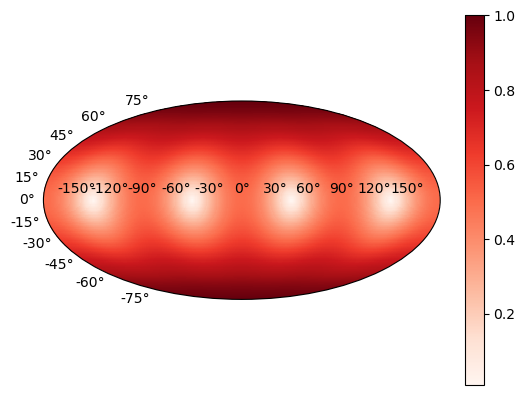

In [89]:
# Mollweide projection of sqrt(F_plus^2 + F_cross^2)

polarization_angle = np.pi/8

# Create coordinate grid for plot (phi in [-pi, pi], theta in [-pi/2, pi/2])
lon = np.linspace(-np.pi, np.pi, 360)
lat = np.linspace(-np.pi/2., np.pi/2.,180)
Lon,Lat = np.meshgrid(lon,lat)

# Create coordinate grid for data (phi in [0, 2pi], theta in [0, pi])
theta_range = np.flip(np.linspace(0, np.pi, 180)) # Flip to match coordinate grid for plot
phi_range = np.linspace(0, 2 * np.pi, 360)
phi_grid, theta_grid = np.meshgrid(phi_range, theta_range)

# Input array for antenna response function corresponding to coordinate grid for data
coordinate_array = [theta_grid, phi_grid, polarization_angle]

# Generate antenna response data
F_plus_data = F(coordinate_array, D)[0]
F_cross_data = F(coordinate_array, D)[1]
data = np.sqrt(np.abs(F_plus_data) ** 2 + np.abs(F_cross_data) ** 2)

# Roll data by 360/2 indexes in phi axis so it matches with coordinate grid
data = np.roll(data, 360/2, 0)

# Plot figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im = ax.pcolormesh(Lon,Lat, data, cmap=plt.cm.Reds) 
plt.colorbar(im)
plt.show()

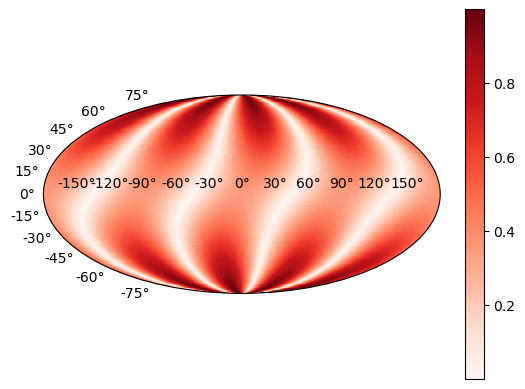

In [90]:
# Mollweide projection of |F_plus|

data = np.abs(F(coordinate_array, D)[0])
data = np.roll(data, 360/2, 0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im = ax.pcolormesh(Lon,Lat,data, cmap=plt.cm.Reds)
plt.colorbar(im)
plt.show()

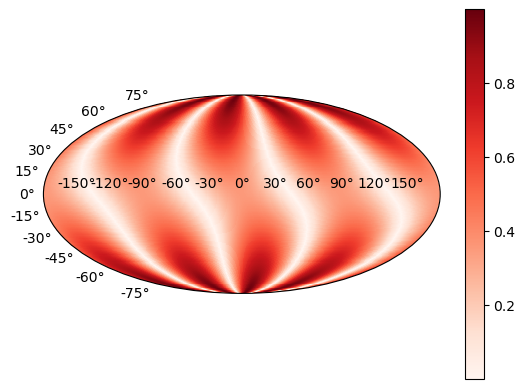

In [91]:
# Mollweide projection of |F_cross|

data = np.abs(F(coordinate_array, D)[1])
data = np.roll(data, 360/2, 0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='mollweide')
im = ax.pcolormesh(Lon,Lat,data, cmap=plt.cm.Reds)
plt.colorbar(im)
plt.show()

In [ ]:
#delta_V = F_plus * h_plus + F_cross * h_cross